# Controlled Simple Transport Model

We use the model described in *Simple_Transport*.
After some imports:

In [1]:
from matplotlib import pyplot as plt
from pymf6.mf6 import MF6
from pymf6.api import create_mutable_bc, find_packages_with_stress_period_data
from pymf6tools.plotting import show_heads, show_well_head, show_concentration
from pymf6tools.make_model import get_simulation
from create_model import create_model

we use a different model path:

In [2]:
model_path_controlled = 'models/pymf6'
name = 'transport'

but buIld exactly the same model:

In [3]:
create_model(model_path_controlled, name)

Now, we can inspect the model by instantiating `MF6` form `pymf6`:

In [4]:
mf6 = MF6(model_path_controlled + '/mfsim.nam', use_modflow_api=True)

We can access the simulations:

In [5]:
sim = mf6.simulation

There are to simulations, one for flow `gwf6` and one for transport `gwt6`:

In [6]:
sim

modeltype,namefile,modelname
gwf6,transport.nam,TRANSPORT
gwt6,gwt_transport.nam,GWT_TRANSPORT


The simulations have different packages:

In [7]:
sim.models

[Model TRANSPORT 
 15 packages
 49 variables.,
 Model GWT_TRANSPORT 
 12 packages
 43 variables.]

There are also two solution groups, one for each simulation:

In [8]:
sim.solution_groups

[Solution 1 
 1 packages
 60 variables.,
 Solution 2 
 1 packages
 60 variables.]

The time discretization is the same for both simulations:

In [9]:
sim.TDIS

number of variables:,20


There are many model variables:

In [10]:
len(mf6.vars)

948

This is an alternative method to get the number of simulations:

In [11]:
mf6._mf6.get_subcomponent_count()

2

There are two models, a flow model `gwf` and a tranport model `gwt`:

In [12]:
gwf = mf6.models['gwf6']
gwt = mf6.models['gwt6']

We specify a linear relationship between the concentration at the right border
and the pumping rate:

In [13]:
concs_rates = [
    (2.3, -0.6),
    (2.2, -0.5),
    (2.1, -0.4),
    (2.0, -0.3),
    (1.9, -0.2),
    (1.8, -0.1),
]

We make the well boundary condition mutable:

In [14]:
wel = create_mutable_bc(gwf.wel)

Now, we can inspect all wells:

In [15]:
wel

,nodelist,q,CONCENTRATION
0,"(0, 1, 4)",0.0,0.0
1,"(0, 2, 4)",0.0,0.0
2,"(0, 3, 4)",0.0,0.0
3,"(0, 4, 4)",0.0,0.0
4,"(0, 5, 4)",0.0,0.0
5,"(0, 6, 4)",0.0,0.0
6,"(0, 7, 4)",0.0,0.0
7,"(0, 8, 4)",0.0,0.0


We can access each value separately:

In [16]:
wel.q?

Type:        property
String form: <property object at 0x12fd9cae0>
Docstring:   stress period data for q

In [17]:
wel.q

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
Name: q, dtype: float64

How do we know that the model offers an attribute `wel`? 
We can look for all packages that have stress period data:

In [18]:
find_packages_with_stress_period_data(gwf)

['wel-1', 'chd-1']

Here `wel` is same was `wel-1`:

In [19]:
gwf.wel is getattr(gwf, 'wel-1')

True

The transport models doesn't have any packages with stress period data:

In [20]:
find_packages_with_stress_period_data(gwt)

[]

Now we iterate over all time steps and modify the pumping rate based on the
concentration at the right model boundary:

In [21]:
for time_step in mf6.steps:
    # slice for all layers, all rows, right column
    modelled_conc = gwt.X[:, :, -1].max()
    for conc, rate in concs_rates:
        if modelled_conc > conc:
            wel.q = rate
            break
    else:  # no `break` reached
        wel.q = 0
modelled_conc

1.9499941023391911

This is the highest concentration at the right hand side at the end of the controlled
model run:

In [22]:
round(modelled_conc, 2)

1.95

The heads show that the well pumping reverts the flow direction, 
i.e. the flow is now from the right model border towards the well.

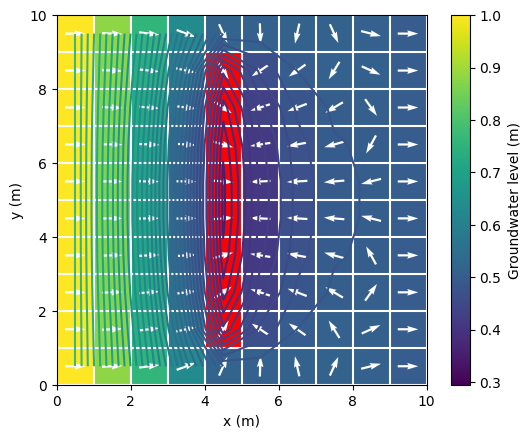

In [23]:
show_heads(model_path=model_path_controlled, name=name, title='');

The target concentration of about 2 mg/L at the right border has
been achieved:

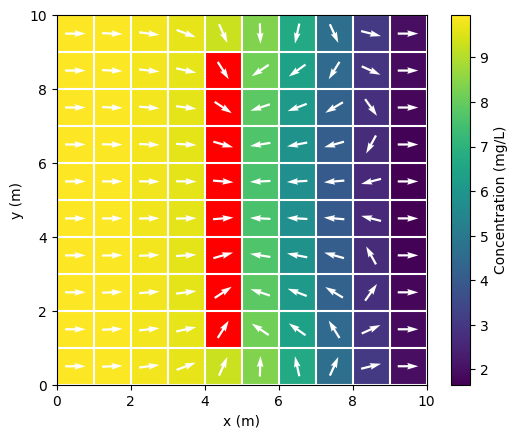

In [24]:
show_concentration(model_path=model_path_controlled, name=name, show_contours=False, show_arrows=True, show_rivers=False);
plt.savefig('conc.svg', bbox_inches='tight')